## Blog Post

### Why did we cared? What was our motivation?

* prevention of future displacements
* prediction vs correlaction
    * forcasting / avoiding
    * model
* idea of causality
    * prediction is closer (with all the pitfalls)

### What did we do?
* we tried out a lot
* we checked all avaible data from wb
* combine wb with idmc
* we selected from wb all indicators with sufficent data avaible
    * only those in relavtive terms
    * we used lasso regression on multiple subset of the data
    * considered as most frequently as predicitive
    * predicted log of displacemts, because: 
        * exponential nature of displacements
        * multiple orders of magnitude
    * IDMC is not recording 0 displacemtns, therefore we if displacment, then magnitude
    * we found the best configuration leading to acceptible (r2 = 0.16) predictive model
    * missing values for indicators where filled with the mean

* we validated our results
    * aggregation over years

### What are our results?
* discussed below

### What can we conclude, what can we not conclude?
* causlitiy
    * not really
* but:
   * economy, enviroment, edjucation and privat sector seems to be most important to reduce the impact of distaster in terms of displacement
* basic infrastucture and security at home is most important

### What are our conclusions?
* conclusion: 
   * datascience is hard
   * data is hard interpretate
   * more and more reliable data would be great
* would like to explore other approaches (considering hiricay and special information)
* other methods
* starting point for further research (intersting results to check further)
* learning experiance



In [2]:
!pip3 install git+http://github.com/ReDI-School/python-data-science > /dev/null 2>&1 && echo 'Installed our ReDI library.'
!pip3 install pandas_datareader > /dev/null 2>&1 && echo 'Installed pandas_datareader.'
!pip3 install html5lib > /dev/null 2>&1 && echo 'Installed html5lib.'
!pip3 install seaborn==0.9.0 > /dev/null 2>&1 && echo 'Installed newest seaborn.'
!pip install mapboxgl > /dev/null 2>&1 && echo 'Installed  mapboxgl.'
!pip install geopandas > /dev/null 2>&1 && echo 'Installed  geopandas.'
!echo '!!!!!!!!!! Restart runtime after installing dependencies !!!!!!!!!!!'

Installed our ReDI library.
Installed pandas_datareader.
Installed html5lib.
Installed newest seaborn.
Installed  mapboxgl.
Installed  geopandas.
!!!!!!!!!! Restart runtime after installing dependencies !!!!!!!!!!!


In [3]:
import math
import numpy as np
import pandas as pd
from pandas_datareader import wb
import statsmodels.api as sm
from sklearn.metrics import r2_score

import seaborn as sns
from matplotlib import pyplot as plt

# Import methods for feature vector building and data pre-procesing
from redi.ws_18.idmc_project.utils import get_dataset, shuffle_cross_validation
from redi.ws_18.idmc_project.display import extract_factors_dataframe_from_ols_summary

from IPython.display import Image
import warnings
warnings.simplefilter(action='ignore')

np.random.seed(23)
import warnings
warnings.filterwarnings('ignore')

from scipy.special import logit

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Selecting indicators

all indicator
*  sufficient coverage
*  expressed in relative numbers
*  no index relative to baseline (because these tend to change quickly over time) 



In [4]:
# Open csv with more complete relative indicators
headers = ["indicator","parent_category","child_category","indicator_code","relative"]
selected_indicators_url = "https://raw.githubusercontent.com/ReDI-School/python-data-science/master/redi/ws_18/idmc_project/selected_indicators.csv"
indicators = pd.read_csv(selected_indicators_url)
indicators.columns = headers
indicator_selected = indicators[indicators['relative'] == 'T']
indicator_selected = indicator_selected[~indicator_selected.indicator.str.contains('= 100')]
indicator_selected.head()

,indicator,parent_category,child_category,indicator_code,relative
0,Population growth (annual %),life_quality,demographics,SP.POP.GROW,T
1,Urban population (% of total),politics_environment,demographics,SP.URB.TOTL.IN.ZS,T
2,Urban population growth (annual %),politics_environment,demographics,SP.URB.GROW,T
3,Rural population (% of total population),politics_environment,demographics,SP.RUR.TOTL.ZS,T
4,"Primary education, duration (years)",politics_environment,education,SE.PRM.DURS,T


### Indicator Category Map

In [0]:
wb_indicators = wb.get_indicators()

wb_indicators_expanded = wb_indicators.set_index('name')['topics'].str.split(" *; *", expand=True).reset_index()
wb_indicators_melt = wb_indicators_expanded.melt(id_vars='name', var_name='idx_cat', value_name='category').dropna()
wb_indicators_melt['category'] = wb_indicators_melt['category'].str.extract('^(.*?) *$')
wb_indicators_melt = wb_indicators_melt[wb_indicators_melt['category'] != '']

In [6]:
wb_indicators.topics.value_counts()

                                                                                   9425
Social Protection & Labor                                                          2299
Education                                                                          1404
Health                                                                              554
Economy & Growth                                                                    200
External Debt                                                                       198
Financial Sector                                                                    145
Poverty                                                                             129
Gender                                                                              122
Private Sector ; Trade                                                              103
Public Sector                                                                        78
Education  ; Gender             

In [7]:
wb_indicators_melt.head()

,name,idx_cat,category
0,Poverty Headcount ($1.90 a day),0,Poverty
1,Poverty Headcount ($2.50 a day),0,Poverty
2,Middle Class ($10-50 a day) Headcount,0,Poverty
3,Official Moderate Poverty Rate-National,0,Poverty
4,Poverty Headcount ($4 a day),0,Poverty


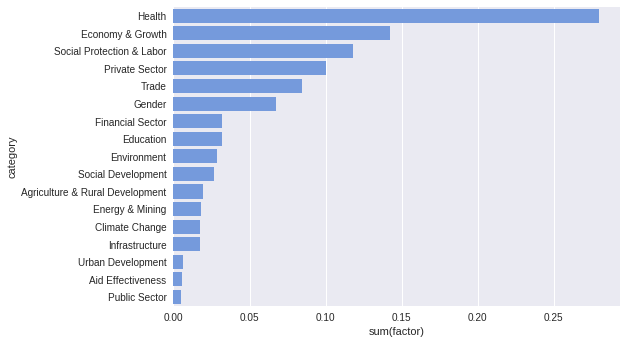

In [8]:
wb_indicators_selected = wb_indicators_melt[wb_indicators_melt['name'].str.strip().isin(indicator_selected['indicator'].str.strip())]
assert indicator_selected['indicator'].nunique() == wb_indicators_selected['name'].nunique()

wb_indicators_selected['count'] = wb_indicators_selected.groupby('name')['category'].transform('count')
wb_indicators_selected['factor'] = 1 / wb_indicators_selected['count']
wb_indicators_selected['factor'] = wb_indicators_selected['factor'] / wb_indicators_selected['factor'].sum()
wb_indicators_selected['cat_sum'] = wb_indicators_selected.groupby('category')['factor'].transform('sum')
wb_indicators_selected = wb_indicators_selected.sort_values('cat_sum', ascending=False)
sns.barplot(data=wb_indicators_selected, x='factor', y='category', estimator=np.sum, ci=None, color="cornflowerblue")

# Loading, Transforming Data



1.   ???
2.   ???



In [0]:
conflict, disaster = get_dataset(list(indicator_selected['indicator_code']))

In [0]:
indexed = disaster.set_index(['iso3c', 'year'])
y_dis = indexed['disasterDisplacementsNorm']
x_dis_all = indexed.drop(columns=['disasterDisplacementsNorm'], axis=1)
y_dis_logit = logit(y_dis)
y_dis_log = np.log(y_dis)

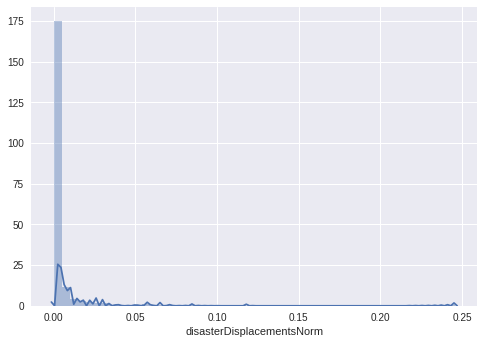

In [11]:
sns.distplot(y_dis)

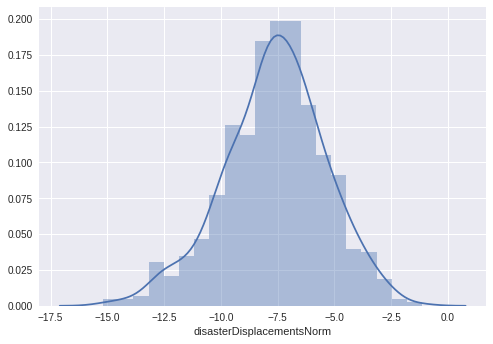

In [12]:
sns.distplot(y_dis_logit)

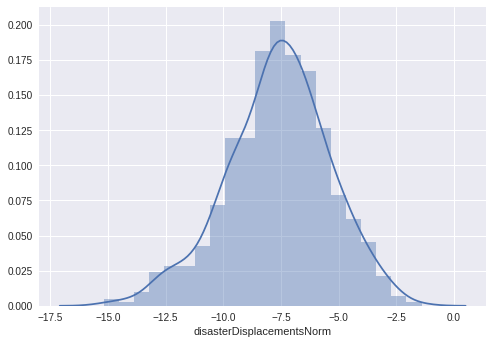

In [13]:
sns.distplot(y_dis_log)

# Implement Lasso Regularization for the disaster displacements


# Feature selection with Lasso Regularization
## Hyperparameter Optimisation

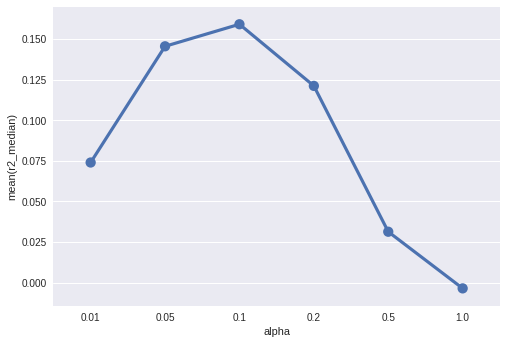

In [14]:

# Run cross validation creating 100 sets
test_size = 0.3
n_splits = 100
alphas = [1, 0.5, 0.2, 0.1, 0.05, 0.01]
r2_median = []
for alpha in alphas:
    all_coef, all_scores = shuffle_cross_validation(x_dis_all, y_dis_log, test_size, n_splits, alpha=alpha)
    r2_median.append(pd.Series(all_scores).median())

alpha_grid = pd.DataFrame({'alpha': alphas, 'r2_median': r2_median})
sns.pointplot(data=alpha_grid, x='alpha', y='r2_median')

In [15]:
alpha_grid

,alpha,r2_median
0,1.00,-0.003524
1,0.50,0.031343
2,0.20,0.121108
3,0.10,0.159057
4,0.05,0.145482
5,0.01,0.073954


Using a alpha of 0.1 to select indicators.

In [0]:
best_alpha = 0.1
shuffle_coef_dis, shuffle_scores_dis = shuffle_cross_validation(x_dis_all, y_dis_log, test_size, n_splits, alpha=best_alpha)

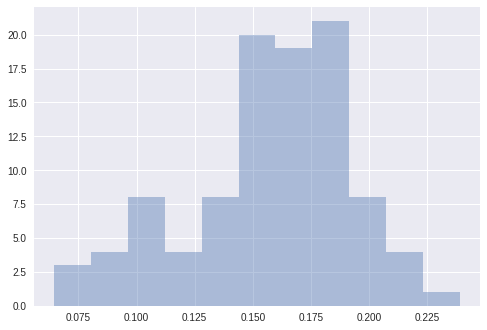

In [17]:
sns.distplot(shuffle_scores_dis, kde=False)

In [18]:
# Visualize results
shuffle_coef_dis_count = shuffle_coef_dis.groupby('indicator')['coef'].agg(['median', 'count'])
shuffle_coef_dis_count.sort_values('count', ascending=False).head()

,median,count
indicator,,
"Preprimary education, duration (years)",-0.153799,99
Merchandise exports to low- and middle-income economies in Middle East & North Africa (% of total merchandise exports),-0.222558,99
Proportion of seats held by women in national parliaments (%),-0.187730,99
Lower secondary school starting age (years),-0.167977,98
Labor tax and contributions (% of commercial profits),-0.136275,98


In [0]:
coef_selected = shuffle_coef_dis_count[shuffle_coef_dis_count['count'] > 66]
coef_selected_list = coef_selected.index.tolist()

In [20]:
wb_indicators_lasso = wb_indicators_melt[wb_indicators_melt['name'].str.strip().isin(coef_selected.index.str.strip())]
set(coef_selected.index.unique()) - set(wb_indicators_lasso['name'].unique())

set()

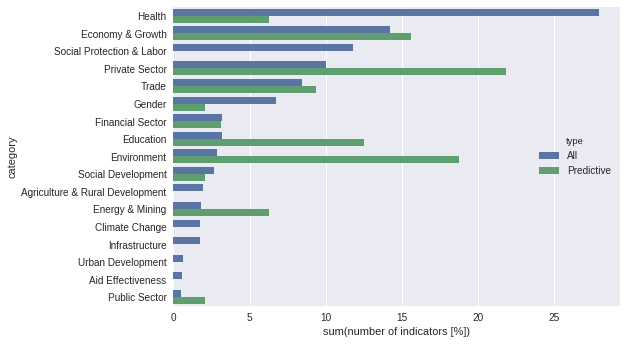

In [21]:
wb_indicators_lasso = wb_indicators_melt[wb_indicators_melt['name'].str.strip().isin(coef_selected.index.str.strip())]
assert coef_selected.index.nunique() == wb_indicators_lasso['name'].nunique()

wb_indicators_lasso['count'] = wb_indicators_lasso.groupby('name')['category'].transform('count')
wb_indicators_lasso['factor'] = 1 / wb_indicators_lasso['count']
wb_indicators_lasso['factor'] = wb_indicators_lasso['factor'] / wb_indicators_lasso['factor'].sum()
wb_indicators_lasso['cat_sum'] = wb_indicators_lasso.groupby('category')['factor'].transform('sum')
wb_indicators_lasso = wb_indicators_lasso.sort_values('cat_sum', ascending=False)
wb_indicators_lasso['type'] = 'Predictive'
wb_indicators_selected['type'] = 'All'
wb_indicators_lasso['number of indicators [%]'] = wb_indicators_lasso['factor'] * 100
wb_indicators_selected['number of indicators [%]'] = wb_indicators_selected['factor'] * 100

sns.barplot(data=pd.concat([wb_indicators_selected, wb_indicators_lasso]), x='number of indicators [%]', y='category', hue='type', estimator=np.sum, ci=None)
# plt.legend(loc='best')

plt.show()

## most relavant
* edjucation
* enviroment
* privat sector
* (energy)

## relevant but not over represented
* economy 
* trade

## Extract most common indicators after Cross Validate results from Lasso Regularization

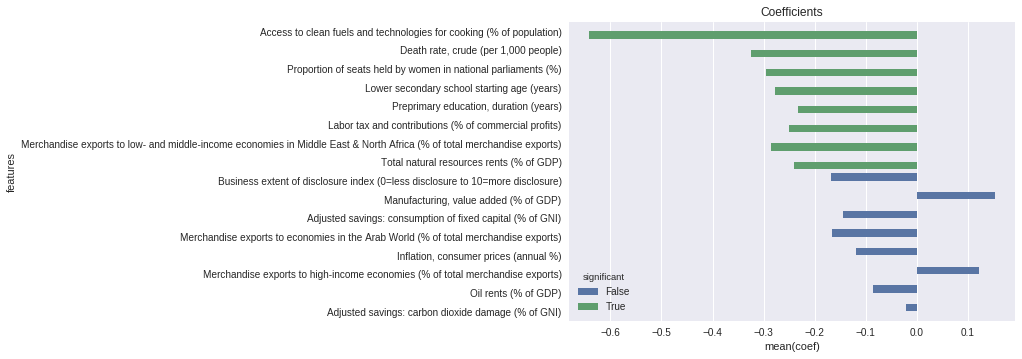

In [23]:
x_dis_selected = indexed[coef_selected_list]

# Add bias
X = sm.add_constant(x_dis_selected.as_matrix())

# Train linear regression and predict internal displacements
mod = sm.OLS(np.array(y_dis_log), X).fit()
y_pred_dis = mod.predict(np.array(X).astype(float))
summary = mod.summary(xname=['const'] + x_dis_selected.columns.tolist())

final_coef = extract_factors_dataframe_from_ols_summary(summary).reset_index().sort_values('P-value')
final_coef['significant'] = final_coef['P-value'] < 0.05
sns.barplot(data=final_coef.iloc[1:], y='features', x='coef', hue='significant')#, dodge=False)
plt.title('Coefficients')
plt.show()

In [24]:
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     13.03
Date:                Fri, 07 Dec 2018   Prob (F-statistic):           3.71e-30
Time:                        13:29:50   Log-Likelihood:                -1328.8
No. Observations:                 639   AIC:                             2692.
Df Residuals:                     622   BIC:                             2767.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================================================================
                                                                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                                                     -7.6297      0.078    -98.290      0.000      -7.782      -7.477
Access to clean fuels and technologies for cooking  (% of population)                                                     -0.6421      0.112     -5.753      0.000      -0.861      -0.423
Adjusted savings: carbon dioxide damage (% of GNI)                                                                        -0.0214      0.088     -0.243      0.808      -0.194       0.151
Adjusted savings: consumption of fixed capital (% of GNI)                                                                 -0.1440      0.089     -1.618      0.106      -0.319       0.031
Business extent of disclosure index (0=less disclosure to 10=more disclosure)                                             -0.1681      0.087     -1.939      0.053      -0.338       0.002
Death rate, crude (per 1,000 people)                                                                                      -0.3252      0.088     -3.688      0.000      -0.498      -0.152
Inflation, consumer prices (annual %)                                                                                     -0.1183      0.081     -1.469      0.142      -0.277       0.040
Labor tax and contributions (% of commercial profits)                                                                     -0.2511      0.093     -2.699      0.007      -0.434      -0.068
Lower secondary school starting age (years)                                                                               -0.2768      0.093     -2.975      0.003      -0.459      -0.094
Manufacturing, value added (% of GDP)                                                                                      0.1524      0.088      1.725      0.085      -0.021       0.326
Merchandise exports to economies in the Arab World (% of total merchandise exports)                                       -0.1660      0.109     -1.524      0.128      -0.380       0.048
Merchandise exports to high-income economies (% of total merchandise exports)                                              0.1223      0.091      1.342      0.180      -0.057       0.301
Merchandise exports to low- and middle-income economies in Middle East & North Africa (% of total merchandise exports)    -0.2847      0.117     -2.428      0.015      -0.515      -0.054
Oil rents (% of GDP)                                                                       

### clean fuel
* basic standart of living important
* makes sense

### death rate
* makes no sense

### exports / imports
* case specific, do not gerneralize, more investigations needed
* more due to location

### women in parlament
* related to democracy
* goverment good
* takeing care of valubale

### natural resources rents
* do not really make sense
* compared to other similar countries better

### tax
* makes sense
* more money 

# Sanity Checks

## Results, when aggregating over years first

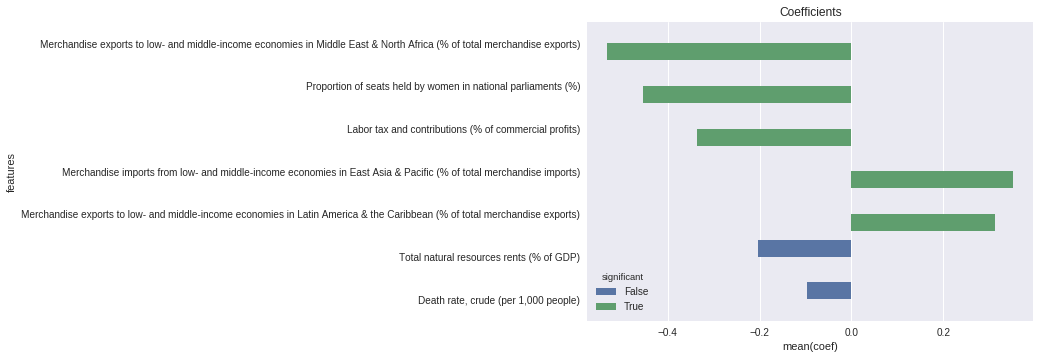

In [29]:
indexed = disaster.set_index(['iso3c', 'year'])
averaged = indexed.groupby('iso3c').mean()
y_dis_av = averaged['disasterDisplacementsNorm']
x_dis_av = averaged.drop(columns=['disasterDisplacementsNorm'], axis=1)
y_dis_av_log = np.log(y_dis_av)

shuffle_coef_dis, shuffle_scores_dis = shuffle_cross_validation(x_dis_av, y_dis_av_log, test_size, n_splits, alpha=best_alpha)
shuffle_coef_dis_count = shuffle_coef_dis.groupby('indicator')['coef'].agg(['median', 'count'])
coef_selected = shuffle_coef_dis_count[shuffle_coef_dis_count['count'] > 66]
coef_selected_list = coef_selected.index.tolist()

x_dis_av_selected = averaged[coef_selected_list]

# Add bias
X = sm.add_constant(x_dis_av_selected.as_matrix())

# Train linear regression and predict internal displacements
mod = sm.OLS(np.array(y_dis_av_log), X).fit()
y_pred = mod.predict(np.array(X).astype(float))
summary = mod.summary(xname=['const'] + x_dis_av_selected.columns.tolist())

final_coef = extract_factors_dataframe_from_ols_summary(summary).reset_index().sort_values('P-value')
final_coef['significant'] = final_coef['P-value'] < 0.05
sns.barplot(data=final_coef.iloc[1:], y='features', x='coef', hue='significant')#, dodge=False)
plt.title('Coefficients')
plt.show()

# Conflicts

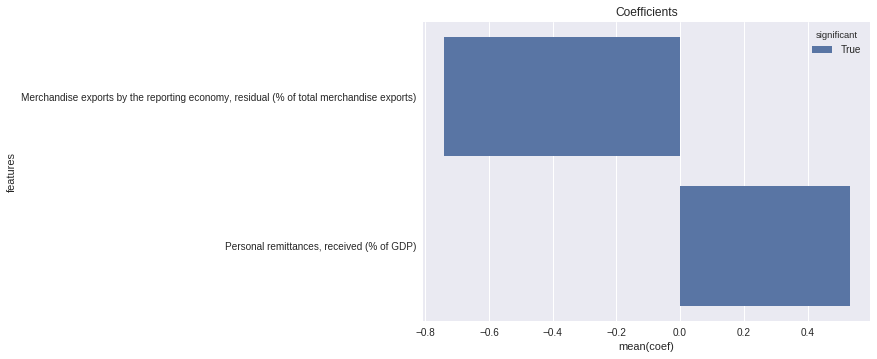

In [28]:
indexed_conf = conflict.set_index(['iso3c', 'year'])
averaged_conf = indexed_conf.groupby('iso3c').mean()
y_conf_av = averaged_conf['conflictDisplacementsNorm']
x_conf_av = averaged_conf.drop(columns=['conflictDisplacementsNorm'], axis=1)
y_conf_av_log = np.log(y_conf_av)

shuffle_coef_conf, shuffle_scores_conf = shuffle_cross_validation(x_conf_av, y_conf_av_log, test_size, n_splits, alpha=best_alpha)
shuffle_coef_conf_count = shuffle_coef_conf.groupby('indicator')['coef'].agg(['median', 'count'])
conf_coef_selected = shuffle_coef_conf_count[shuffle_coef_conf_count['count'] > 66]
conf_coef_selected_list = conf_coef_selected.index.tolist()

x_conf_av_selected = averaged_conf[conf_coef_selected_list]

# Add bias
X = sm.add_constant(x_conf_av_selected.as_matrix())

# Train linear regression and predict internal displacements
mod = sm.OLS(np.array(y_conf_av_log), X).fit()
y_pred = mod.predict(np.array(X).astype(float))
summary = mod.summary(xname=['const'] + x_conf_av_selected.columns.tolist())

final_coef = extract_factors_dataframe_from_ols_summary(summary).reset_index().sort_values('P-value')
final_coef['significant'] = final_coef['P-value'] < 0.05
sns.barplot(data=final_coef.iloc[1:], y='features', x='coef', hue='significant')#, dodge=False)
plt.title('Coefficients')
plt.show()

In [0]:
final_coef

In [27]:
displacementspred_2017 = pd.Series(y_pred_dis, index=x_dis_selected.index)[:, 2017].apply(np.exp)
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world['displacementspred'] = world['iso_a3'].map(displacementspred_2017)
world['displacementspred'] = world['displacementspred'].fillna(0)

import os
from mapboxgl.viz import *
from mapboxgl.utils import *
token = 'pk.eyJ1IjoibGV2aW5icmlua21hbm4iLCJhIjoiY2puYzVrdWE4MXZ5azN4cmZlbGFmMjJuaiJ9.gxSKh7KiwX0sIvwJByy3Pw'

# Must be a public token, starting with `pk`

# create choropleth from polygon features stored as GeoJSON
viz = ChoroplethViz(gdf_to_geojson(world, properties=['displacementspred']), 
                    access_token=token,
                    color_property='displacementspred',
                    color_stops=create_color_stops([0, 0.0001, 0.001, 0.01, 0.1], colors='YlOrRd'),
                    color_function_type='interpolate',
                    line_stroke='--',
                    line_color='rgb(128,0,38)',
                    line_width=1,
                    opacity=0.8,
                    center=(-96, 37.8),
                    zoom=3,
                    below_layer='waterway-label',
                    legend_layout='horizontal',
                    legend_key_shape='bar',
                    legend_key_borders_on=False)
viz.show()